<a href="https://colab.research.google.com/github/josooik/DeepLearning/blob/main/CNN_FeatureMap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MobilenetV2 모델로 CNNN_FeatureMap 만들기

In [149]:
from tensorflow.keras import models, preprocessing, applications

* MobileNetV2를 불러오고
* 이미지를 넣으면 카테고리 확인

### Model Load

In [150]:
mobilenet = applications.MobileNetV2(weights='imagenet')
mobilenet.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

### 함수

In [151]:
import matplotlib.pyplot as plt

def plot_imgs(img1, img2):
  plt.subplot(1,2,1)
  plt.imshow(img)
  plt.axis("off")

  plt.subplot(1,2,2)
  plt.imshow(img2)
  plt.axis("off")
  
  plt.show()

In [152]:
idx = 5

def plot_by_layers(extract_imgs, n_layers=15, n_ch=8):

  plt.figure(figsize=(n_layers * 2, n_ch * 2))

  for idx in range(1, 1 + n_layers):
    layer_idx = 10 * idx # (10, 20 .... 100)
    extract_img = extract_imgs[layer_idx] # (10, 20, ... 100번째 레이어 아웃풋 이미지)

    for ch in range(n_ch):
      plt.subplot(n_ch, n_layers, (idx) + (ch * n_layers))

      if ch == 0: plt.title(layer_idx)
      
      plt.imshow(extract_img[0][:,:,ch])
      plt.axis("off")

  plt.show()

### Preprocess

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


img_arr : (224, 224, 3)
img_pre : (224, 224, 3)


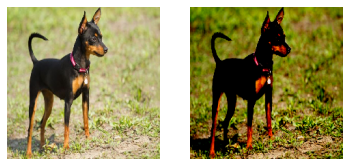

* iniput shape: (1, 224, 224, 3)


In [153]:
import numpy as np

img = preprocessing.image.load_img('dog.jfif', target_size=(224,224))

img_arr = preprocessing.image.img_to_array(img)
print("img_arr :", img_arr.shape)

img_pre = applications.mobilenet_v2.preprocess_input(img_arr)
print("img_pre :",img_pre.shape)

plot_imgs(img, img_pre)

img_for_pred = np.expand_dims(img_pre, 0)
print("* iniput shape:", img_for_pred.shape)

In [154]:
layer_outputs = []

for layer in mobilenet.layers:
  layer_outputs.append(layer.output)

extract_layer_model = models.Model(inputs=mobilenet.input,
                                   outputs=layer_outputs)

### Feature Map

156


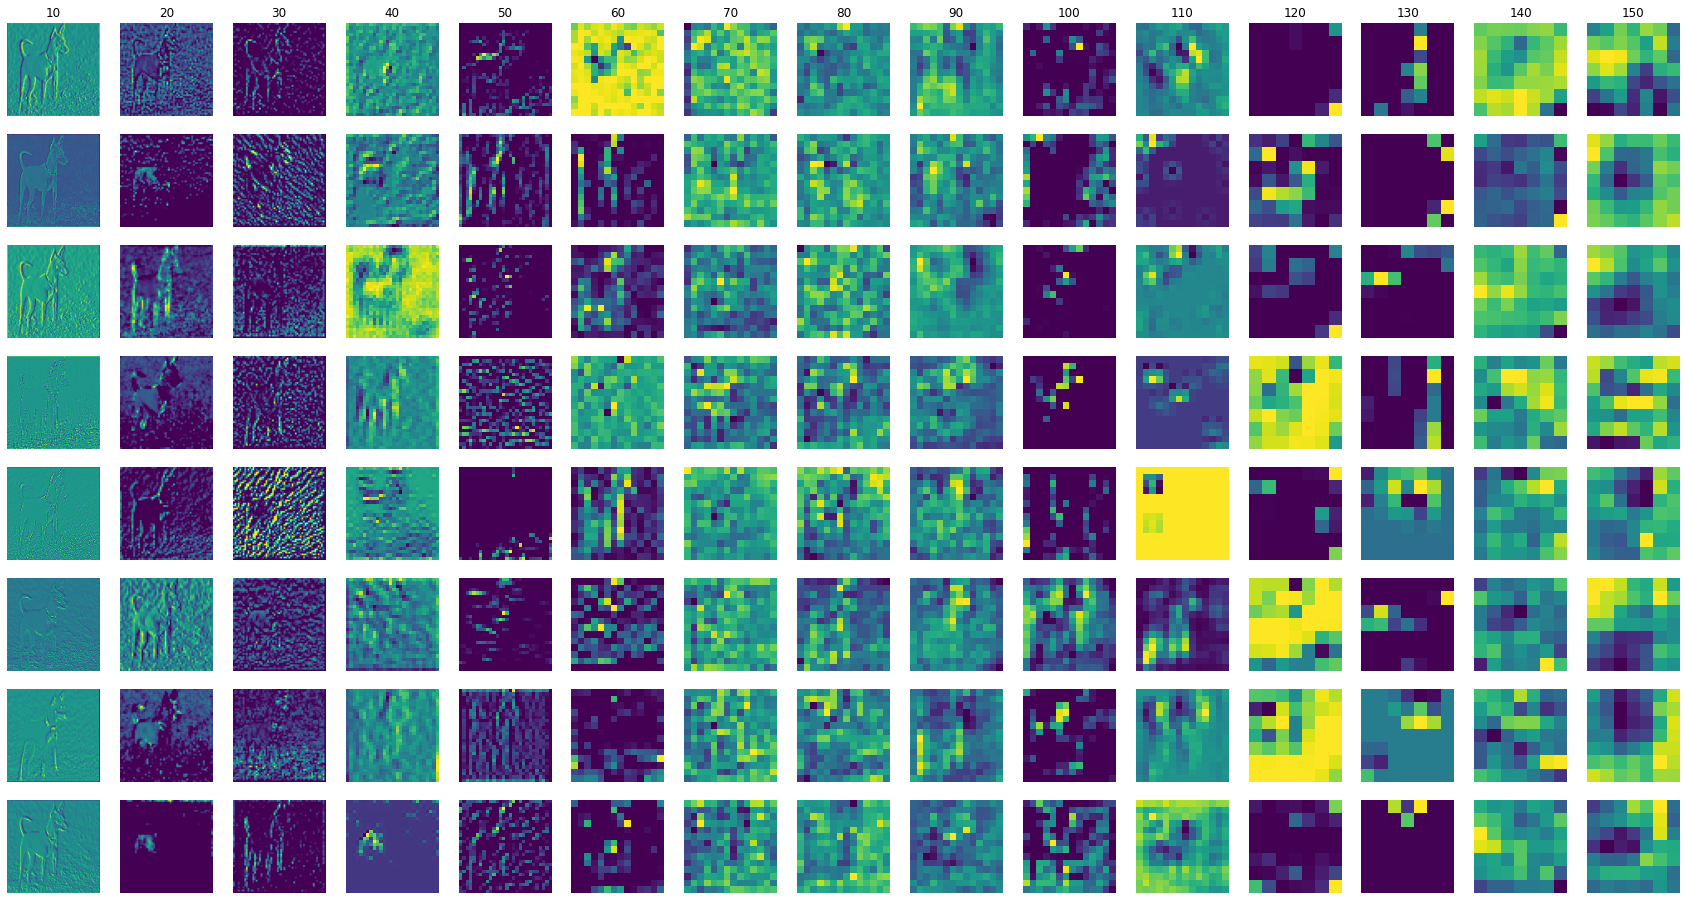

In [155]:
extract_imgs = extract_layer_model(img_for_pred)
print(len(extract_imgs))

plot_by_layers(extract_imgs)

### 예측

In [156]:
# 최종 아웃풋
pred = mobilenet.predict(img_for_pred)
print("* pred shape:", pred.shape)

tag = np.argmax(pred)
print(tag)

* pred shape: (1, 1000)
237


# 모델 : UNet 불러오기
---

![]( https://github.com/yebiny/Image-Segmentation-TF2/blob/main/imgs/unet2.png?raw=true)

### Model Load

In [157]:
from tensorflow.keras import layers, models, Input, utils

In [158]:
!ls

cat.jpeg  dog.jfif  sample_data  unet_chip_1.h5  unet_pet_aug.h5


In [159]:
unet = models.load_model("unet_pet_aug.h5")
unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                           

In [160]:
layer_outputs = []

for layer in unet.layers:
  layer_outputs.append(layer.output)

extract_layer_unet = models.Model(inputs=unet.input,
                                   outputs=layer_outputs)

### 전치리 함수

In [161]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

class DataGenerator():
  def __init__(self, img_size, batch_size):
    self.img_size = img_size
    self.batch_size = batch_size

  def path2arr(self, path, mask=False):
    # img 일때
    if not mask:
      # path -> img
      img = load_img(path, color_mode='rgb', target_size=(self.img_size, self.img_size))
      # img -> arr
      arr = img_to_array(img, dtype='uint8')
    
    # mask 일때
    else:
      # path -> img
      img = load_img(path, color_mode='grayscale', target_size=(self.img_size, self.img_size))
      # img -> arr
      arr = img_to_array(img, dtype='uint8')

    return arr
  
  def load_datasets(self, img_paths, mask_paths):
    img_arrs = []
    mask_arrs = []

    for img_path, mask_path in zip(img_paths, mask_paths):
      img_arr = self.path2arr(img_path)
      img_arrs.append(img_arr)

      mask_arr = self.path2arr(mask_path, mask=True)
      mask_arrs.append(mask_arr)
    
    return np.array(img_arrs), np.array(mask_arrs)
  
  def preprocess(self, img_arr, mask_arr):
    img_arr = (img_arr / 127.5) -1
    mask_arr = mask_arr - 1

    return img_arr, mask_arr
  
  def tf_preprocess(self, img_arr, mask_arr):
    img_arr = (tf.cast(img_arr, tf.float32) / 127.5) -1
    mask_arr = tf.cast(mask_arr, tf.float32) -1 # int -> float

    return img_arr, mask_arr
  
  def augment(slef, img, mask):
    # 밝기랜덤조절
    img = tf.image.random_brightness(img, max_delta=0.5)
    img = tf.clip_by_value(img, -1, 1)

    ds = tf.concat((img, mask), axis=2)
    # 좌우랜덤반전 / 상하랜덤반전
    ds = tf.image.random_flip_left_right(ds)
    ds = tf.image.random_flip_up_down(ds)
    
    # 이미지 사이즈 증가(padding)
    #pd_size = 50
    #img = tf.image.resize_with_crop_or_pad(img, self.img_size + pad_size, self.img_size + pad_size)
    #mask = tf.mask.resize_with_crop_or_pad(mask, self.img_size + pad_size, self.img_size + pad_size)

    # 랜덤크롭
    #ds = tf.cncat((img, mask), axis=2)
    #ds = tf.image.random_crop(ds, size=[self.img_size, self.img_size, 4])
    img, mask = ds[:,:,:3], ds[:,:,-1]
    # img = (256, 256, 3)
    # mask = (256, 256) -> (256, 256,1)
    mask = tf.expand_dims(mask, axis=2)

    return img, mask

  def generate(self, img_paths, mask_paths, aug=False):
    # 기존 Numpy 이용한 데이터셋 처리
    img_arrs, mask_arrs = self.load_datasets(img_paths, mask_paths)

    # tensorflow dataset 라이브러리 사용 여기서부터는 Numpy가 아니라 Tensor 이용
    dataset = tf.data.Dataset.from_tensor_slices((img_arrs, mask_arrs))
    dataset = dataset.map(self.tf_preprocess, num_parallel_calls=tf.data.AUTOTUNE) # 전처리, num_parallel_calls=tf.data.AUTOTUNE -> 병렬처리
    
    if aug:
      dataset.map(self.augment, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(self.batch_size, drop_remainder=True) # batch 사이즈 지정
    print(dataset)

    return dataset

In [162]:
IMG_SIZE = 256
BATH_SIZE = 16
dg = DataGenerator(IMG_SIZE, BATH_SIZE)

### Preprocess

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


img_arr : (256, 256, 3)
img_pre : (256, 256, 3)


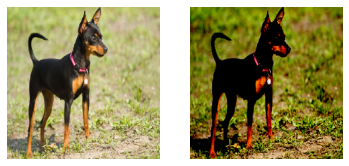

* iniput shape: (1, 256, 256, 3)


In [163]:
import numpy as np

img = preprocessing.image.load_img('dog.jfif', target_size=(256,256))

img_arr = preprocessing.image.img_to_array(img)
print("img_arr :", img_arr.shape)

img_pre = applications.mobilenet_v2.preprocess_input(img_arr)
print("img_pre :",img_pre.shape)

plot_imgs(img, img_pre)

img_for_pred = np.expand_dims(img_pre, 0)
print("* iniput shape:", img_for_pred.shape)

### 예측

In [164]:
pred = unet.predict(np.expand_dims(img_pre, 0))
print(pred.shape)

pred = np.argmax(pred, axis=3)
print(pred.shape)

pred = np.expand_dims(pred[0],2)
print(pred.shape)

(1, 256, 256, 3)
(1, 256, 256)
(256, 256, 1)


### 시각화

In [165]:
def display_img(img, mask, mask_cmap=None):

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1)
    plt.axis("off")
    plt.imshow(img)

    plt.subplot(1,3,2)
    plt.axis("off")
    plt.imshow(img)
    plt.imshow(mask[:,:,0], alpha=0.6, cmap=mask_cmap)

    plt.subplot(1,3,3)
    plt.axis("off")
    plt.imshow(mask[:,:,0], cmap=mask_cmap)

    plt.show()

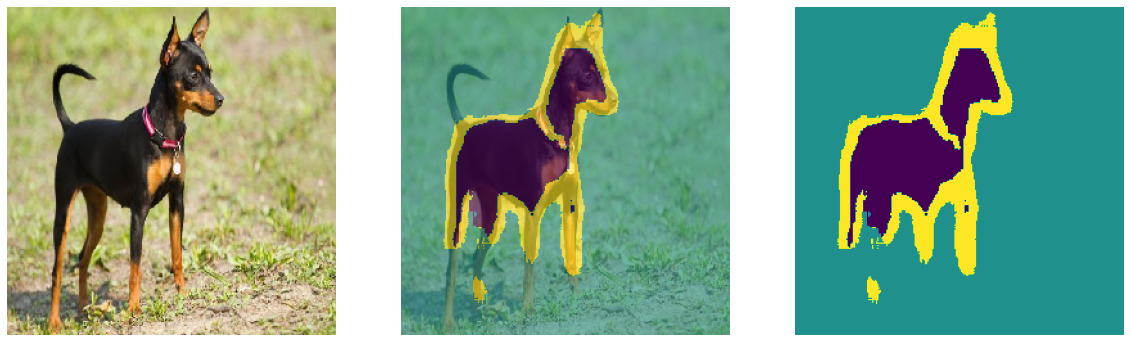

In [166]:
display_img(img, pred)

### Feature Map

72


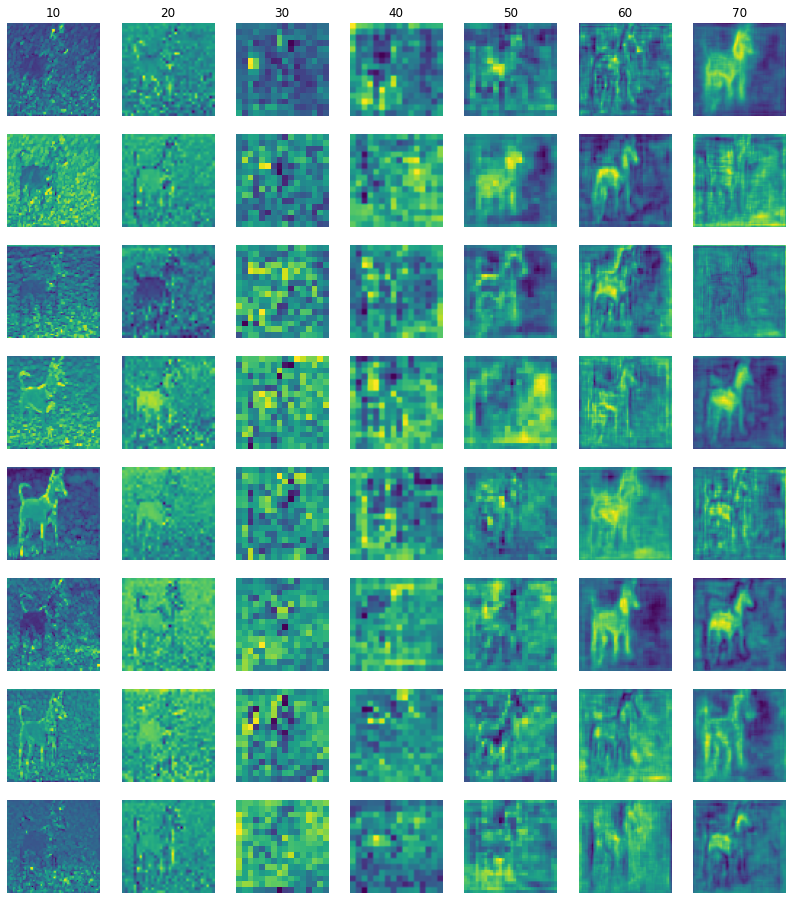

In [167]:
extract_imgs = extract_layer_unet(np.expand_dims(img_pre, 0))
print(len(extract_imgs))

plot_by_layers(extract_imgs, n_layers=7)